# MCMC

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/
# and pymc3 and arviz

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3
    !pip install arviz
    !pip install python graphviz

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

For most of this book we've been using grid methods to approximate posterior distributions.
For models with one or two parameters, grid algorithms are fast and the results are precise enough for most practical purposes.
With three parameters, they start to be computationally-intensive, and with more than three they are usually not practical.

In the previous chapter we saw that we can solve some problems using conjugate priors.
But the problems we can solve this way tend to be the same ones we can solve with grid algorithms.

For problems with more than a few parameters, the most powerful tool we have is MCMC, which stands for "Markov chain Monte Carlo".

In this context, "Monte Carlo" refers to to methods that generate random samples from a distribution.
Unlike grid methods, MCMC methods don't try to compute the posterior distribution; they sample from it instead.

It might seem strange that you can generate sample without ever computing the distribution, but that's the magic of MCMC.

To demonstrate, we'll start by solving the World Cup problem.

## The World Cup problem

In Chapter xxx we solved the World Cup problem:

> In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:
>
> 1. How confident should we be that France is the better team?
>
> 2. If the same teams played again, what is the chance France would win again?

We modeled goal scoring in football (soccer) as a Poisson process characterized by a goal-scoring rate, denoted $\lambda$.

We used a gamma distribution to represent the prior distribution of $\lambda$, then we used to outcome of the game to compute the posterior distribution for both teams.

To answer the first question, we used the posterior distributions to compute the "probability of superiority" for France.

To answer the second question, we computed the posterior predictive distributions for each team, that it, the distribution of goals we expect in a rematch.

In this chapter we'll solve this problem again using PyMC, which is a library that provides implementation of several MCMC methods.
But we'll start by reviewing the grid approximation of the prior and the prior predictive distribution.

## Grid approximation

As we did in Chapter 8xxx we'll use a gamma distribution with parameter $\alpha=1.4$ to represent the prior.

In [4]:
from scipy.stats import gamma

alpha = 1.4
dist = gamma(alpha)

I'll use `linspace` to generate an array of possible values for $\lambda$, and `pmf_from_dist` to compute a discrete approximation of the prior.

In [5]:
import numpy as np
from utils import pmf_from_dist

lams = np.linspace(0, 10, 101)
gamma_prior = pmf_from_dist(dist, lams)

Here's what it looks like.

In [8]:
from utils import decorate

def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    decorate(xlabel=r'Goals per game ($\lambda$)',
        ylabel=ylabel,
        title='Prior distribution of goal scoring rate')

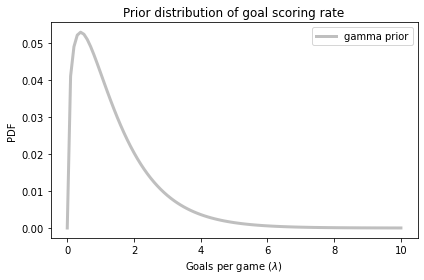

In [9]:
gamma_prior.plot(label='gamma prior', color='C5')
decorate_rate()

## Prior Predictive Distribution

Now, before we compute the posterior, we'll take a detour to compute the "prior predictive distribution".
We have seen the posterior predictive distribution in previous chapters; the prior predictive distribution is similar, except that (as you might have guessed) it is based on the prior.

To estimate the prior predictive distribution, I'll start by drawing a sample from the prior.

In [10]:
sample_prior = gamma_prior.sample(1000, replace=True)

`sample_prior` is an array of possible values for the goal-scoring rate, $\lambda$.

For each value in `sample_prior`, I'll generate one value from a Poisson distribution.

In [11]:
from scipy.stats import poisson

sample_prior_pred = poisson.rvs(sample_prior)

The result is a sample from the prior predictive distribution.
We can use it to estimate the PMF:

In [15]:
from empiricaldist import Pmf

pmf_prior_pred = Pmf.from_seq(sample_prior_pred)

And here's what it looks like:

In [18]:
from utils import decorate

def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    decorate(xlabel='Number of goals',
        ylabel=ylabel,
        title='Distribution of goals scored')

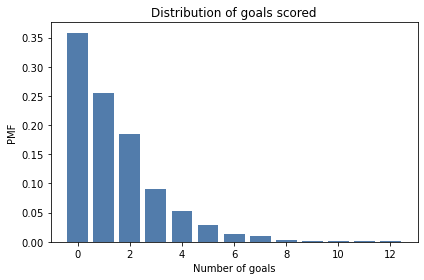

In [19]:
pmf_prior_pred.bar()
decorate_goals()

One reason to compute the prior predictive distribution is to check whether out model of the system seems reasonable.
In this case, the distribution of goals scored is consistent with what we know about goal scoring in World Cup football.

But in this chapter we have another reason: computing the prior predictive distribution is a first step toward using MCMC.

## Introducing PyMC

PyMC is a Python library that provides several MCMC methods.
To use PyMC, we have to specify a model of the process that generates the data.
In this example, the model has two steps:

* First we draw a goal-scoring rate from the prior distribution,

* Then we draw a number of goals from a Poisson distribution.

Here's how we specify this model in PyMC:

In [23]:
import pymc3 as pm

with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

After importing `pymc3`, we create a `Model` object named `model`.
If you are not familiar with the `with` statement in Python, it is a way to associate a block of statements with an object.
In this example, the two indented statements are associated with the new `Model` object so that when we create the distribution objects, `Gamma` and `Poisson`, they are added to the `Model`.

Inside the `with` statement:

* The first line creates the prior, which is a gamma distribution with the given parameters.

* The second line creates the prior predictive, which is a Poisson distribution with the parameter `lam`.

The first parameter of `Gamma` and `Poisson` is a string variable name.

PyMC provides a function that generates a visual representation of the model.

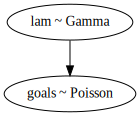

In [25]:
pm.model_to_graphviz(model)

In this visualization, the ovals show that `lam` is drawn from a gamma distribution and `goals` is drawn from a Poisson distribution.
The arrow shows that the values of `lam` are the parameters of distribution of `goals`.

PyMC provides a function that generates samples from the prior predictive distribution.
We can use a `with` statement to run this function in the context of the model.

In [26]:
with model:
    trace = pm.sample_prior_predictive(1000)

In [ ]:
sample_prior_pymc = trace['mu']
np.mean(sample_prior_pymc)

And compare it to a sample from the gamma prior.

In [ ]:
gamma_prior.make_cdf().plot(label='prior gamma')
plot_cdf(sample_prior_pymc, label='prior pymc')
decorate_rate('CDF')

It looks pretty good.

## Prior predictive

The distributions of `goals` from this model is the prior predictive.

In [ ]:
sample_prior_pred_pymc = trace['goals']
np.mean(sample_prior_pred_pymc)

And let's compare it to a prior predictive distribution estimated by sampling.

In [ ]:
sample_prior_pred = np.random.poisson(sample_prior_gamma)
np.mean(sample_prior_pred)

In [ ]:
def plot_pred(sample, **options):
    cdf = Cdf.from_seq(sample)
    cdf.step(**options)

In [ ]:
plot_pred(sample_prior_pred, label='prior pred grid')
plot_pred(sample_prior_pred_pymc, label='prior pred PyMC')
decorate_goals('CDF')

Looks good.

## Grid Update

In [ ]:
from scipy.stats import poisson

data = 4
likelihood = poisson.pmf(data, mus)

In [ ]:
posterior = gamma_prior * likelihood
posterior.normalize()

In [ ]:
gamma_prior.plot(label='prior', color='C5')
posterior.plot(label='posterior', color='C4')
decorate_rate()

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of called `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [ ]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

In [ ]:
len(trace['mu'])

In [ ]:
with model:
    pm.plot_posterior(trace)

We can extract a sample of `mu` from the trace.

In [ ]:
sample_post_pymc = trace['mu']
np.mean(sample_post_pymc)

And compare it to the sample we drew from the grid approximation:

In [ ]:
sample_post_grid = posterior2.sample(1000, replace=True)
sample_post_grid.mean()

In [ ]:
plot_cdf(sample_post_grid, label='posterior grid')
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_rate()

Again, it looks pretty good.

## Posterior predictive

To sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

In [ ]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

Here's what it looks like:

In [ ]:
sample_post_pred_pymc = post_pred['goals']
np.mean(sample_post_pred_pymc)

In [ ]:
sample_post_pred = poisson(sample_post_grid).rvs()
sample_post_pred.mean()

In [ ]:
plot_pred(sample_post_pred, label='posterior pred grid')
plot_pred(sample_post_pred_pymc, label='posterior pred PyMC')
decorate_goals()

Looks pretty good!